In [2]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from itertools import product

##### Generate the synthetic data

In [3]:
# Generate data
np.random.seed(0)
X = np.random.randn(1000, 10)
y = X @ np.random.randn(10) + np.random.randn(1000)

# Introduce noise in the data
noise_rate = 0.2
y_noisy = y.copy()
n_noisy = int(noise_rate * y.shape[0])
noise_indices = np.random.choice(y.shape[0], n_noisy, replace=False)
y_noisy[noise_indices] += np.random.randn(n_noisy)  # Add noise

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_noisy, test_size=0.2, random_state=42)

##### Implement Canal Adaptive Elastic Net

In [4]:
class CanalAdaptiveElasticNet:
    def __init__(self, lambda1=0.1, lambda2=0.1, gamma=0.1, zeta=0.1, learning_rate=0.01):
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.gamma = gamma
        self.zeta = zeta
        self.learning_rate = learning_rate
        self.beta = None
        self.scaler = StandardScaler()

    def canal_loss(self, z, epsilon, delta):
        return np.minimum(delta, np.maximum(0, np.abs(z) - epsilon))

    def compute_gradient(self, x, z, beta, epsilon, delta):
        if -epsilon - delta < z < -epsilon:
            grad = -x + 2 * self.lambda2 * beta + self.lambda1 * (-self.gamma * np.sign(beta) * np.abs(beta) ** (-self.gamma - 1) * np.abs(beta) + np.sign(beta) * np.abs(beta) ** (-self.gamma))
        elif epsilon < z < epsilon + delta:
            grad = x + 2 * self.lambda2 * beta + self.lambda1 * (-self.gamma * np.sign(beta) * np.abs(beta) ** (-self.gamma - 1) * np.abs(beta) + np.sign(beta) * np.abs(beta) ** (-self.gamma))
        else:
            grad = 2 * self.lambda2 * beta + self.lambda1 * (-self.gamma * np.sign(beta) * np.abs(beta) ** (-self.gamma - 1) * np.abs(beta) + np.sign(beta) * np.abs(beta) ** (-self.gamma))
        return grad

    def fit(self, X, y):
        X = self.scaler.fit_transform(X)
        n_samples, n_features = X.shape
        self.beta = np.random.randn(n_features) * 0.01  # Small random initialization
        
        for t in range(n_samples):
            x_t = X[t]
            y_t = y[t]
            y_pred_t = np.dot(x_t, self.beta)
            z_t = y_pred_t - y_t
            epsilon = self.zeta * np.mean(np.abs(y_pred_t) + np.abs(y_t))
            delta = self.gamma * np.mean(np.abs(y_pred_t) + np.abs(y_t))
            grad = self.compute_gradient(x_t, z_t, self.beta, epsilon, delta)
            self.beta -= self.learning_rate * grad

    def predict(self, X):
        X = self.scaler.transform(X)
        return np.dot(X, self.beta)

#### Perform Hyperparameter Tuning

In [5]:
# Define the grid of hyperparameters
param_grid = {
    'lambda1': [0.01, 0.1, 1],
    'lambda2': [0.01, 0.1, 1],
    'gamma': [0.01, 0.1, 1],
    'zeta': [0.01, 0.1, 1],
    #'learning_rate': [0.001, 0.01, 0.1]
    'learning_rate': [0.01, 0.1, 0.3]

}

# Create a list of all combinations of hyperparameters
param_combinations = list(product(param_grid['lambda1'], param_grid['lambda2'], param_grid['gamma'], param_grid['zeta'], param_grid['learning_rate']))

# Initialize variables to store the best hyperparameters and lowest MSE
best_params = None
lowest_mse = float('inf')

# Grid search over all combinations of hyperparameters
for params in param_combinations:
    lambda1, lambda2, gamma, zeta, learning_rate = params
    model = CanalAdaptiveElasticNet(lambda1=lambda1, lambda2=lambda2, gamma=gamma, zeta=zeta, learning_rate=learning_rate)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    if mse < lowest_mse:
        lowest_mse = mse
        best_params = params

# Print the best hyperparameters and the corresponding MSE
print("Best Hyperparameters:", best_params)
print("Lowest MSE:", lowest_mse)

Best Hyperparameters: (0.01, 0.01, 1, 0.01, 0.01)
Lowest MSE: 1.0561894173330149


#### Compare Canal-Adaptive Elastic Net to other classical models

In [6]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Train Canal-Adaptive Elastic Net model using the best hyperparameters
model_canal = CanalAdaptiveElasticNet(lambda1=0.1, lambda2=0.01, gamma=1, zeta=0.01, learning_rate=0.01)
model_canal.fit(X_train, y_train)

# Predict and evaluate the Canal-Adaptive Elastic Net model
y_pred_canal = model_canal.predict(X_test)
mse_canal = mean_squared_error(y_test, y_pred_canal)
print("MSE of Canal-Adaptive Elastic Net:", mse_canal)

# Fit ElasticNet
model_elastic = ElasticNet(alpha=0.1, l1_ratio=0.5)  # alpha is the penalty term, l1_ratio controls the mix of L1 vs L2
model_elastic.fit(X_train, y_train)

predicted_elastic = model_elastic.predict(X_test)
mse_elastic = mean_squared_error(y_test, predicted_elastic)
print("MSE of Elastic Net:", mse_elastic)

# Fit Lasso
model_lasso = Lasso(alpha=0.1)
model_lasso.fit(X_train, y_train)

predicted_lasso = model_lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, predicted_lasso)
print("MSE of Lasso:", mse_lasso)

# Fit Ridge
model_ridge = Ridge(alpha=0.1)
model_ridge.fit(X_train, y_train)

predicted_ridge = model_ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, predicted_ridge)
print("MSE of Ridge:", mse_ridge)

MSE of Canal-Adaptive Elastic Net: 1.0523101460343023
MSE of Elastic Net: 1.15560906622092
MSE of Lasso: 1.1782830187579945
MSE of Ridge: 1.0232747967279607


Noise Level: 0
  Lasso: MSE = 1.16747891987464
  Ridge: MSE = 1.0199052404899738
  ElasticNet: MSE = 1.1250021465016924
  Canal-Adaptive Elastic Net: MSE = 4.1443948164110145
Noise Level: 0.1
  Lasso: MSE = 1.9367318317868043
  Ridge: MSE = 1.768940286279539
  ElasticNet: MSE = 1.877797565085793
  Canal-Adaptive Elastic Net: MSE = 4.468724751088881
Noise Level: 0.2
  Lasso: MSE = 2.598270366929912
  Ridge: MSE = 2.4791894109047767
  ElasticNet: MSE = 2.5338999250284227
  Canal-Adaptive Elastic Net: MSE = 4.801922863621938
Noise Level: 0.3
  Lasso: MSE = 2.934326482845772
  Ridge: MSE = 2.8537727787203475
  ElasticNet: MSE = 2.877005944681922
  Canal-Adaptive Elastic Net: MSE = 4.969141246875379


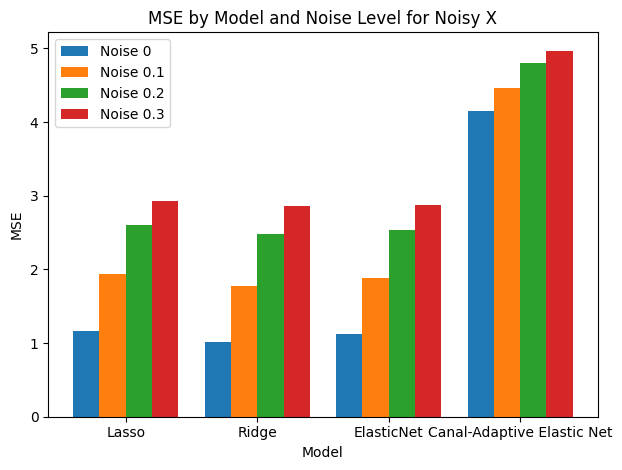

Noise Level: 0
  Lasso: MSE = 1.2190114408412347
  Ridge: MSE = 1.0470762521421613
  ElasticNet: MSE = 1.1690280426753037
  Canal-Adaptive Elastic Net: MSE = 4.10692397184024
Noise Level: 0.1
  Lasso: MSE = 1.2672260338430301
  Ridge: MSE = 1.1282236944895947
  ElasticNet: MSE = 1.2276217324507432
  Canal-Adaptive Elastic Net: MSE = 3.9797300678897423
Noise Level: 0.2
  Lasso: MSE = 1.3596350375216963
  Ridge: MSE = 1.2426206703030114
  ElasticNet: MSE = 1.3254414920634472
  Canal-Adaptive Elastic Net: MSE = 4.052501462447454
Noise Level: 0.3
  Lasso: MSE = 1.4986263483677043
  Ridge: MSE = 1.3646341564832414
  ElasticNet: MSE = 1.454787284108532
  Canal-Adaptive Elastic Net: MSE = 4.402237460038735


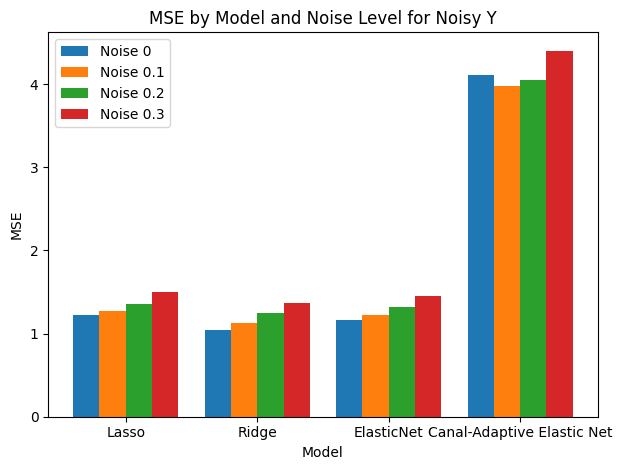

In [12]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Simulate data with noisy explanatory variable
def simulate_data_with_noisy_x(n_samples, n_features, noise_level, beta_true):
    X = np.random.randn(n_samples, n_features)
    y = X @ beta_true + np.random.randn(n_samples)
    # Introduce noise in explanatory variables
    n_noisy = int(noise_level * n_samples)
    noise_indices = np.random.choice(n_samples, n_noisy, replace=False)
    X[noise_indices, :] += np.random.randn(n_noisy, n_features)
    return X, y

# Simulate data with noisy response variable
def simulate_data_with_noisy_y(n_samples, n_features, noise_level, beta_true):
    X = np.random.randn(n_samples, n_features)
    y = X @ beta_true + np.random.randn(n_samples)
    # Introduce noise in response variable
    n_noisy = int(noise_level * n_samples)
    noise_indices = np.random.choice(n_samples, n_noisy, replace=False)
    y[noise_indices] += np.random.randn(n_noisy)
    return X, y

# Canal-Adaptive Elastic Net class
class CanalAdaptiveElasticNet:
    def __init__(self, lambda1=0.1, lambda2=0.1, gamma=0.1, zeta=0.1, learning_rate=0.01):
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.gamma = gamma
        self.zeta = zeta
        self.learning_rate = learning_rate
        self.beta = None
        self.scaler = StandardScaler()

    def canal_loss(self, z, epsilon, delta):
        return np.minimum(delta, np.maximum(0, np.abs(z) - epsilon))

    def compute_gradient(self, x, z, beta, epsilon, delta):
        if -epsilon - delta < z < -epsilon:
            grad = -x + 2 * self.lambda2 * beta + self.lambda1 * (-self.gamma * np.sign(beta) * np.abs(beta) ** (-self.gamma - 1) * np.abs(beta) + np.sign(beta) * np.abs(beta) ** (-self.gamma))
        elif epsilon < z < epsilon + delta:
            grad = x + 2 * self.lambda2 * beta + self.lambda1 * (-self.gamma * np.sign(beta) * np.abs(beta) ** (-self.gamma - 1) * np.abs(beta) + np.sign(beta) * np.abs(beta) ** (-self.gamma))
        else:
            grad = 2 * self.lambda2 * beta + self.lambda1 * (-self.gamma * np.sign(beta) * np.abs(beta) ** (-self.gamma - 1) * np.abs(beta) + np.sign(beta) * np.abs(beta) ** (-self.gamma))
        return grad

    def fit(self, X, y):
        X = self.scaler.fit_transform(X)
        n_samples, n_features = X.shape
        self.beta = np.random.randn(n_features) * 0.01  # Small random initialization
        
        for t in range(n_samples):
            x_t = X[t]
            y_t = y[t]
            y_pred_t = np.dot(x_t, self.beta)
            z_t = y_pred_t - y_t
            epsilon = self.zeta * np.mean(np.abs(y_pred_t) + np.abs(y_t))
            delta = self.gamma * np.mean(np.abs(y_pred_t) + np.abs(y_t))
            grad = self.compute_gradient(x_t, z_t, self.beta, epsilon, delta)
            self.beta -= self.learning_rate * grad

    def predict(self, X):
        X = self.scaler.transform(X)
        return np.dot(X, self.beta)

# Experiment setup
n_samples = 200
n_features = 10
beta_true = np.full(n_features, 0.85)
noise_levels = [0, 0.1, 0.2, 0.3]
results_x = {noise: {"Lasso": [], "Ridge": [], "ElasticNet": [], "Canal-Adaptive Elastic Net": []} for noise in noise_levels}
results_y = {noise: {"Lasso": [], "Ridge": [], "ElasticNet": [], "Canal-Adaptive Elastic Net": []} for noise in noise_levels}

# Run experiments for noisy x
for noise_level in noise_levels:
    for _ in range(20):  # 20 randomized trials
        X, y = simulate_data_with_noisy_x(n_samples, n_features, noise_level, beta_true)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        # Lasso
        lasso = Lasso(alpha=0.1)
        lasso.fit(X_train, y_train)
        y_pred = lasso.predict(X_test)
        results_x[noise_level]["Lasso"].append(mean_squared_error(y_test, y_pred))

        # Ridge
        ridge = Ridge(alpha=0.1)
        ridge.fit(X_train, y_train)
        y_pred = ridge.predict(X_test)
        results_x[noise_level]["Ridge"].append(mean_squared_error(y_test, y_pred))

        # Elastic Net
        enet = ElasticNet(alpha=0.1, l1_ratio=0.5)
        enet.fit(X_train, y_train)
        y_pred = enet.predict(X_test)
        results_x[noise_level]["ElasticNet"].append(mean_squared_error(y_test, y_pred))

        # Canal-Adaptive Elastic Net
        model_canal = CanalAdaptiveElasticNet(lambda1=0.1, lambda2=0.01, gamma=1, zeta=0.01, learning_rate=0.01)
        model_canal.fit(X_train, y_train)
        y_pred = model_canal.predict(X_test)
        results_x[noise_level]["Canal-Adaptive Elastic Net"].append(mean_squared_error(y_test, y_pred))

# Calculate average results for noisy x
avg_results_x = {noise: {method: np.mean(scores) for method, scores in methods.items()} for noise, methods in results_x.items()}

# Print results for noisy x
for noise, methods in avg_results_x.items():
    print(f"Noise Level: {noise}")
    for method, score in methods.items():
        print(f"  {method}: MSE = {score}")

# Visualize the results for noisy x
labels = list(avg_results_x[0].keys())
x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots()
for i, noise in enumerate(noise_levels):
    mse_values = [avg_results_x[noise][method] for method in labels]
    ax.bar(x + i*width, mse_values, width, label=f'Noise {noise}')

ax.set_xlabel('Model')
ax.set_ylabel('MSE')
ax.set_title('MSE by Model and Noise Level for Noisy X')
ax.set_xticks(x + width * (len(noise_levels) - 1) / 2)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

# Run experiments for noisy y
for noise_level in noise_levels:
    for _ in range(20):  # 20 randomized trials
        X, y = simulate_data_with_noisy_y(n_samples, n_features, noise_level, beta_true)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        # Lasso
        lasso = Lasso(alpha=0.1)
        lasso.fit(X_train, y_train)
        y_pred = lasso.predict(X_test)
        results_y[noise_level]["Lasso"].append(mean_squared_error(y_test, y_pred))

        # Ridge
        ridge = Ridge(alpha=0.1)
        ridge.fit(X_train, y_train)
        y_pred = ridge.predict(X_test)
        results_y[noise_level]["Ridge"].append(mean_squared_error(y_test, y_pred))

        # Elastic Net
        enet = ElasticNet(alpha=0.1, l1_ratio=0.5)
        enet.fit(X_train, y_train)
        y_pred = enet.predict(X_test)
        results_y[noise_level]["ElasticNet"].append(mean_squared_error(y_test, y_pred))

        # Canal-Adaptive Elastic Net
        model_canal = CanalAdaptiveElasticNet(lambda1=0.1, lambda2=0.01, gamma=1, zeta=0.01, learning_rate=0.01)
        model_canal.fit(X_train, y_train)
        y_pred = model_canal.predict(X_test)
        results_y[noise_level]["Canal-Adaptive Elastic Net"].append(mean_squared_error(y_test, y_pred))

# Calculate average results for noisy y
avg_results_y = {noise: {method: np.mean(scores) for method, scores in methods.items()} for noise, methods in results_y.items()}

# Print results for noisy y
for noise, methods in avg_results_y.items():
    print(f"Noise Level: {noise}")
    for method, score in methods.items():
        print(f"  {method}: MSE = {score}")

# Visualize the results for noisy y
labels = list(avg_results_y[0].keys())
x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots()
for i, noise in enumerate(noise_levels):
    mse_values = [avg_results_y[noise][method] for method in labels]
    ax.bar(x + i*width, mse_values, width, label=f'Noise {noise}')

ax.set_xlabel('Model')
ax.set_ylabel('MSE')
ax.set_title('MSE by Model and Noise Level for Noisy Y')
ax.set_xticks(x + width * (len(noise_levels) - 1) / 2)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()
